In [1]:
!pip install mlxtend

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


In [2]:
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from pandas.api.types import is_numeric_dtype

from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn import utils

from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from mlxtend.plotting import plot_decision_regions

from tester import dump_classifier_and_data
from feature_format import featureFormat, targetFeatureSplit

sys.path.append("../tools/")

#from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data

%matplotlib inline

In [4]:
### Load the dictionary containing the dataset
# with open("final_project_dataset.pkl", "r") as data_file:
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))
    
    
### Load the dictionary containing the processed text from the emails
### Code is in vectorize_text.py - heavily borrowed from the scripts used in the text learning module
## as well as the email_preprocess module
email_dict = pickle.load(open("email_text.pkl", "r"))    

In [5]:
##convert dictionary to dataframe for easier manipulation

df = pd.DataFrame.from_dict(data_dict, orient="index")


for x, y in email_dict.items():
    email_dict[x] = ''.join(y)

df_email_text = pd.DataFrame.from_dict(email_dict,orient="index")

df_email_text.rename(index=str,columns={0:'email_text'}, inplace=True)

In [6]:
df = pd.merge(left=df,right=df_email_text,how='left',left_on='email_address',right_index=True)

In [7]:
### Task 2: Remove outliers
#fillna did not work (likely due to NaN being strings, not np.nan), so use replace
df.replace("NaN",0,inplace=True)

df.drop("TOTAL", inplace = True)

df.poi = df.poi.astype(int)

df.drop(columns=['email_address'],inplace=True)

In [8]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.85,
                             stop_words='english',max_features=10000)

email_transformed = vectorizer.fit_transform(df['email_text'].fillna(''))
terms = vectorizer.get_feature_names()


### feature selection, because text is super high dimensional and 
### can be really computationally chewy as a result
# selector = SelectPercentile(f_classif, percentile=80)
# selector.fit(X_train_email_transformed, df['poi'])
# X_train_email = selector.transform(X_train_email_transformed).toarray()
# X_test_email  = selector.transform(X_test_email_transformed).toarray()


## https://stackoverflow.com/questions/41724432/ml-getting-feature-names-after-feature-selection-selectpercentile-python
## https://stackoverflow.com/questions/9296658/how-to-filter-a-numpy-array-using-another-arrays-values

# support = np.asarray(selector.get_support(),'bool')

# terms = np.asarray(terms)

# selected_feature_names = terms[support]


##https://stackoverflow.com/questions/30653642/combining-bag-of-words-and-other-features-in-one-model-using-sklearn-and-pandas


In [9]:
df_email_transformed = pd.DataFrame(email_transformed.toarray(),columns=terms)


df = df.join(df_email_transformed,rsuffix='et_')
df.drop(columns=['email_text'], inplace=True)

In [10]:

## process data
## process_data function accepts a few different arguments, allowing me to scale, resample, and filter the features
## https://elitedatascience.com/imbalanced-classes

def process_data(data,label_column='poi',scale=0,rsmpl=0,feature_list=None):    
    ##Resample first, if needed
    ##https://stackoverflow.com/questions/52735334/python-pandas-resample-dataset-to-have-balanced-classes    
    
    if rsmpl:
        
        df_majority = data[data[label_column]==0]
        df_minority = data[data[label_column]==1]      

        # Upsample minority class
        df_minority_upsampled = utils.resample(df_minority.copy(),
                                         n_samples=50,
                                         replace=True     # sample with replacement
                                        )
        
        ## because we are resampling, and we need to export the data to a dictionary, we need to add some
        ## randomness to the resampled names
        new_index_names = []
        for i, j in enumerate(df_minority_upsampled.index):
            new_index_names.append(j + '_' + str(np.random.random()))
            
            
        df_minority_upsampled.index = new_index_names
        
        # Combine majority class with upsampled minority class
        data = pd.concat([df_majority, df_minority_upsampled,df_minority])
            
            
    ##separate features from labels
    
    features = data.drop(columns=[label_column])
    labels = data[label_column]      
    
    if feature_list:
        features = features[feature_list]          
        
    if scale:
        for x in features.columns:
            if is_numeric_dtype(features[x]):
                features[x] = preprocessing.scale(features[x])        
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels)
    
    return X_train, X_test, y_train, y_test, data

In [11]:
df = df.fillna(0)

X_train, X_test, y_train, y_test, df = process_data(df,rsmpl=1)#, feature_list=['bonus','total_stock_value','other'])

In [12]:
## https://machinelearningmastery.com/feature-selection-machine-learning-python/

# Feature Importance with Extra Trees Classifier

# load data
et_clf = ExtraTreesClassifier(n_estimators=100)
et_clf.fit(X_train, y_train)

fs = et_clf.feature_importances_

df_feature_importance = pd.DataFrame(fs,index=X_train.columns)

df_feature_importance = df_feature_importance.sort_values(by=0, ascending=False)

In [13]:
df_feature_importance = df_feature_importance[df_feature_importance[0] >= .06].reset_index()

chosen_features = df_feature_importance['index']

X_train = X_train[chosen_features]

X_test = X_test[chosen_features]

## assign to feature_list, which will be used when we dump the data at the end of the script
feature_list = chosen_features

print(df_feature_importance)

                     index         0
0  shared_receipt_with_poi  0.098063
1                   salary  0.079454
2                 expenses  0.071357
3  exercised_stock_options  0.070050
4  from_poi_to_this_person  0.067370
5         restricted_stock  0.067138
6  from_this_person_to_poi  0.063854
7        total_stock_value  0.061734
8                    other  0.061064
9                    bonus  0.060231


In [14]:
## Pulled in the GaussianNB classifier when attempting to use text data
## Ended up removing the text, but this still gives pretty decent results

gb = GaussianNB()

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

cr = classification_report(y_test, y_pred)

print(gb.score(X_test,y_test))
print(cr)

0.7755102040816326
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        32
           1       1.00      0.35      0.52        17

   micro avg       0.78      0.78      0.78        49
   macro avg       0.87      0.68      0.69        49
weighted avg       0.83      0.78      0.74        49



In [15]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier function. 

clf = SVC(kernel='rbf',C=1000,gamma='scale',random_state=12)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print(round(clf.score(X_test,y_test),2))
cr = classification_report(y_test, y_pred)

print(cr)

0.86
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        32
           1       0.78      0.82      0.80        17

   micro avg       0.86      0.86      0.86        49
   macro avg       0.84      0.85      0.84        49
weighted avg       0.86      0.86      0.86        49



0.9795918367346939
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.94      1.00      0.97        17

   micro avg       0.98      0.98      0.98        49
   macro avg       0.97      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49



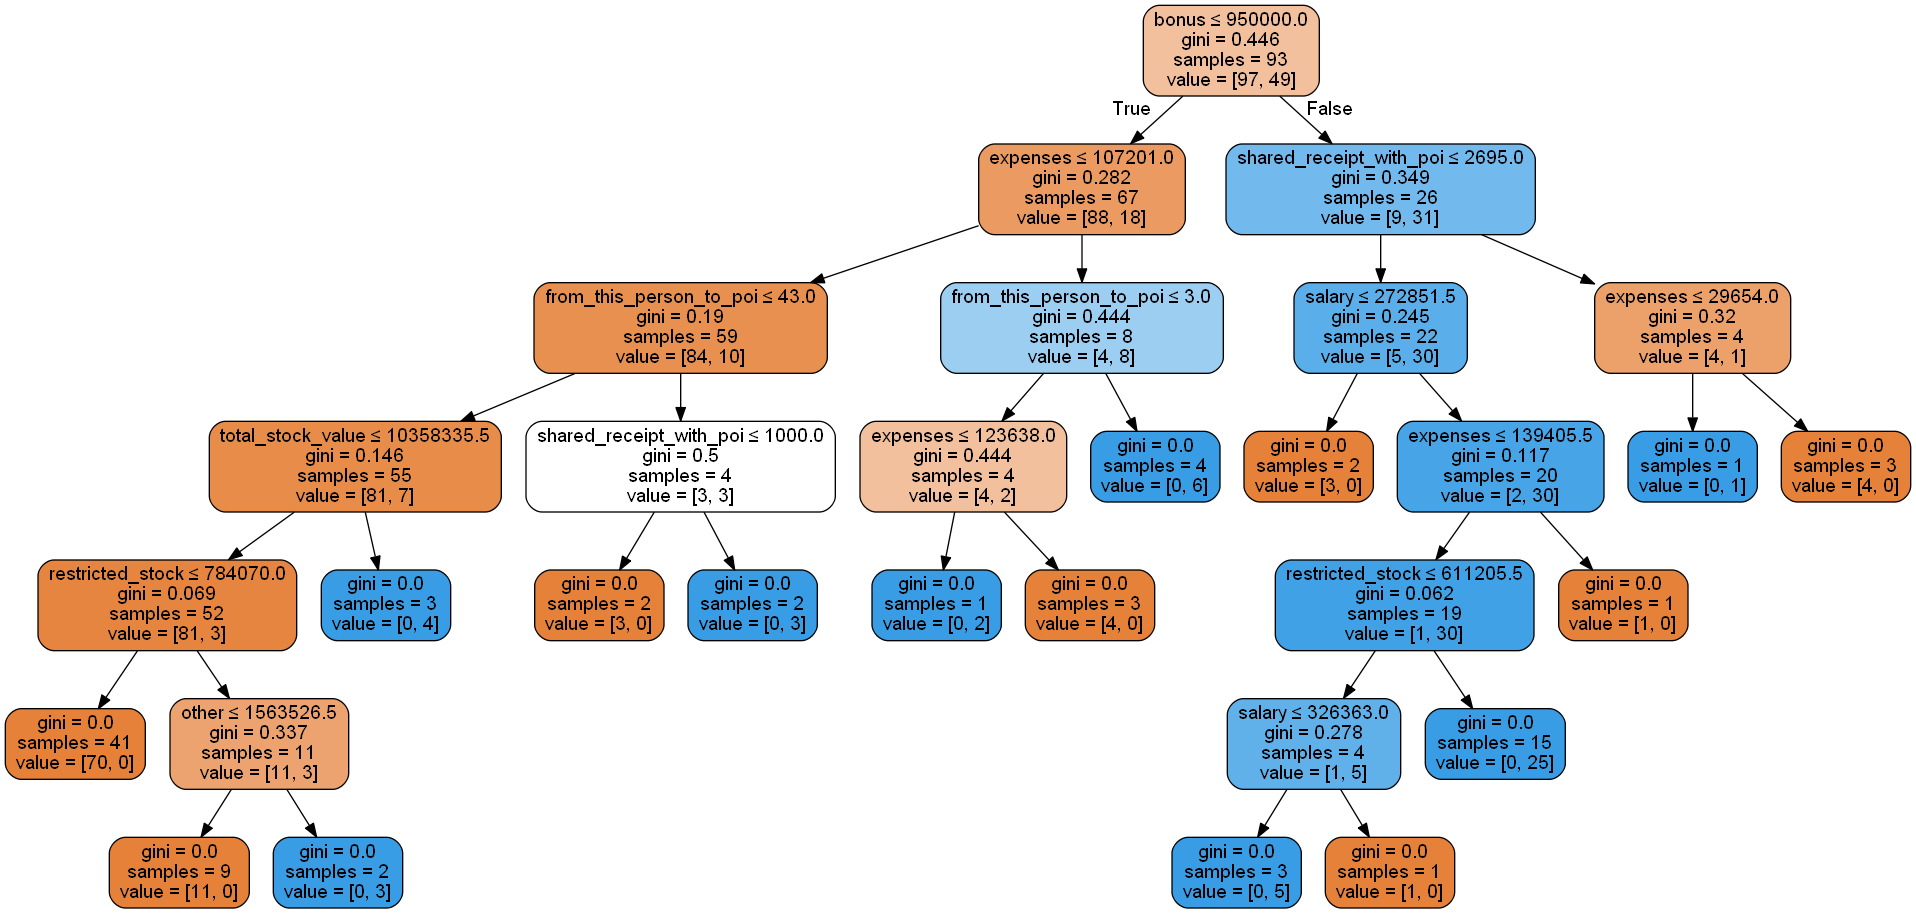

In [16]:
##https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

rf_clf = None

rf_clf = RandomForestClassifier(min_samples_split=3, n_estimators=150, random_state = 12)

rf_clf.fit(X_train,y_train)


y_pred = rf_clf.predict(X_test)

cr = classification_report(y_test, y_pred)

print(rf_clf.score(X_test,y_test))
print(cr)

dot_data = StringIO()
export_graphviz(rf_clf.estimators_[1], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True
               ,feature_names =chosen_features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



In [17]:
dt_clf = tree.DecisionTreeClassifier()

parameters = {"min_samples_split":[2,3,4,5],"max_features":[None,2,3,4,5,], "random_state":[40]}

Grid_CV = GridSearchCV(dt_clf, parameters, cv =4)

Grid_CV.fit(X_train,y_train)

Grid_CV.best_params_

C:\Users\jcsmi329\AppData\Local\Continuum\anaconda3\envs\python_2_7\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 2, 'min_samples_split': 2, 'random_state': 40}

0.8979591836734694
              precision    recall  f1-score   support

           0       1.00      0.84      0.92        32
           1       0.77      1.00      0.87        17

   micro avg       0.90      0.90      0.90        49
   macro avg       0.89      0.92      0.89        49
weighted avg       0.92      0.90      0.90        49



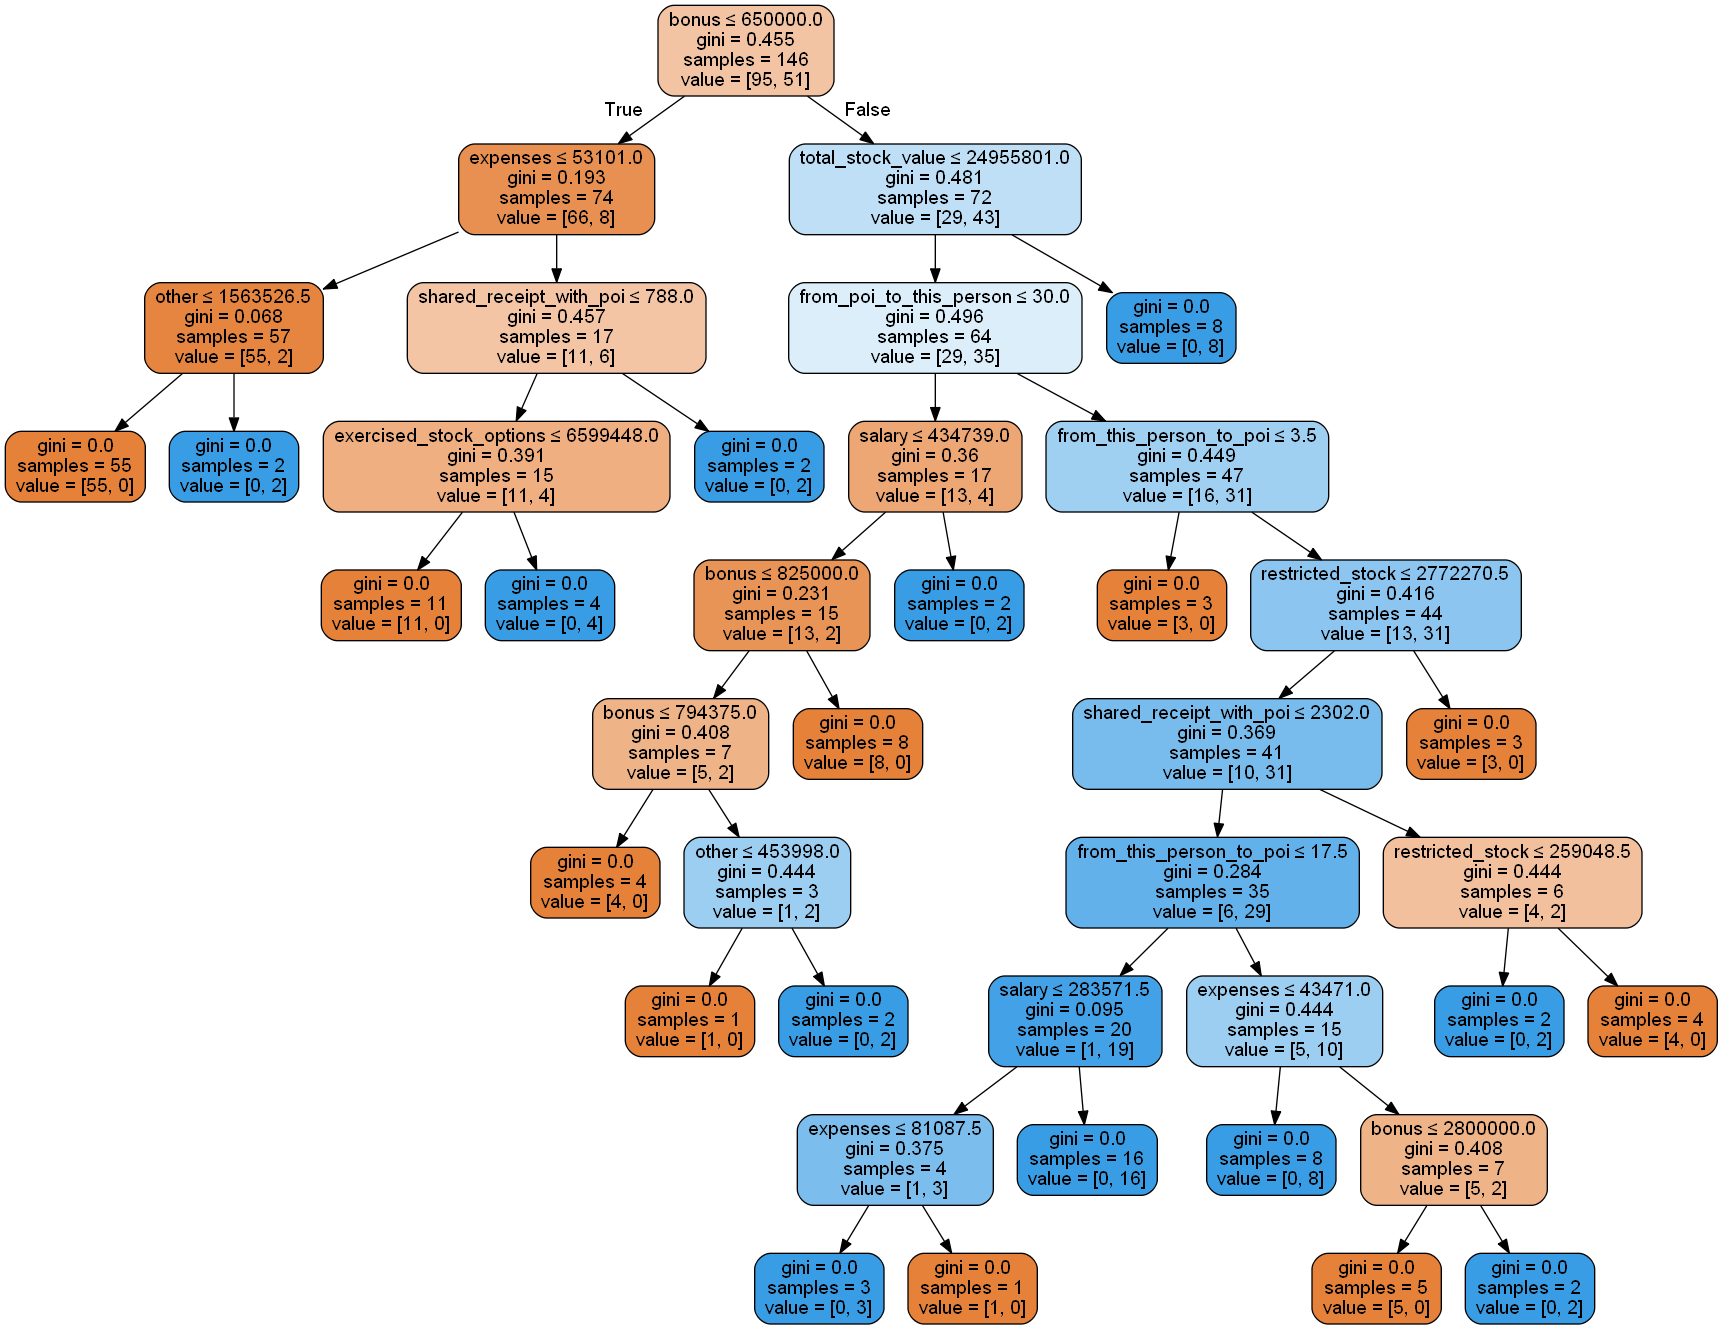

In [18]:
## https://stackoverflow.com/questions/27122757/sklearn-set-params-takes-exactly-1-argument/29028601

dt_clf.set_params(**Grid_CV.best_params_)

dt_clf.fit(X_train,y_train)

dt_clf.score(X_test,y_test)

clf = dt_clf

y_pred = dt_clf.predict(X_test)

print(dt_clf.score(X_test,y_test))
cr = classification_report(y_test, y_pred)

print(cr)

dot_data = StringIO()
export_graphviz(dt_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True
               ,feature_names =chosen_features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [19]:
feature_list = list(feature_list)
if feature_list[0] != 'poi':
    feature_list.insert(0, 'poi')

In [20]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = df.to_dict('index')

feature_labels = X_train.columns

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.



dump_classifier_and_data(clf, my_dataset, feature_list)

##### Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

The goal of this project is to use the given data that we have about the Enron employees financial and email data to try and determine which were/would have been persons of interest in the investigation. Machine learning is a very useful tool here, because there is a lot of data (especially in the emails) and a lot of patterns - the financial data alone has roughly 20 features. It is hard for humans to find patterns out of this much data, so we turn to machine learning to help.

There are multiple ways to use the data to determine if someone is a POI - I attempted two of them. The first is to use this financial + email dataset to see if there are any patterns in the financial or email numbers that correlate with someone being a POI. Another way of looking at this is to use the actual email text to find patters - when I did this in my vectorize_text.py script, I was getting a score of around 90, with a recall of .5 and a precision of .89 - which was a much simpler and quicker way of getting high accuracy compared to using this dataset.

The only outlier I noticed was the "Total" record, which had numbers way higher than any other record. Once I removed this record, I didn't see any other large outliers, so I left the rest of the potential outliers in.


##### What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

I ended up using 9 features - every feature that my ExtraTreeClassifier had listed as greater than or equal to .06 importance.

I did not do any scaling - I attempted scaling, but found that whenever I did scale the features, my performance suffered. I'm not sure if this is due a technical issue on my end, or the data itself.

I did attempt to engineer features - using the text from the emails in the emails_by_address folder. I did this work in vectorize_text.py file - I copied very heavily from the Text Learning module code, as well as email_preprocess.py from the Naive Bayes module.

The features were to be the top X number of text features from the emails that would improve the model. I used a TfIdf Vectorizer and SelectPercentile with an 80th percentile filter. However, when I ran these features through the ExtraTreeClassifier, all of these features had an importance of 0. I'm not sure what I could have done differently here, but I do know that I will need to spend more time on this the next time I attempt something like this.

Lastly, while I did not do any scaling, I did resample my POI data. The reason for this was that there are so few records in the dataset, especially POI records, that it was very hard to train my models to a rate of precision and recall higher than .3. By resampling the data, I added more training records for the POI records, which gave my models more data to learn and predict.


##### What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

I ended up going with a Decision Tree Classifier. This gave me the highest precision and recall. The Random Forest Classifier had the same precision and recall, however the Decision Tree Classifier is easier to explain and understand, so I chose this one. I also tried an SVM and a Naive Bayes classifier - the SVM struggled, and when I was looking at the produced plots, I could see why - the way it separates the data points didn't work well with the patterns in the dataset. The Naive Bayes did very well in my text vectorizer model, however it did not perform as well with the financial + email dataset.

Note - scores below will be different, but close, as the model is re-ran (This note is mostly to myself, as it took me longer than I'd like to admit to realize that the reason my scores were changing is because I was getting different records in my training and test datasets each time I re-ran this script.)

The SVM and Naive Bayes classifiers had decent precision - NB was at .83 and the SVM was at .77. While the SVM had a recall of 1, the NB classifier was only at .29. This is compared to the .89 in precision for both the Random Forest and the Decision Tree and 1 for recall, so the SVM and NB performed significantly worse.

##### What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

Tuning an algorithm is to find what parameters for that algorithm give you the best performance. Without tuning your algorithms, you can have much worse performance

I tuned the parameters for the Random Forest and SVM by hand, but I attempted to use the GridSearchCV on the decision tree classifier. After some time learning how to best use this, I ended up automating the selection of the parameters for the Decision Tree Classifier, with the parameters I tuned being min_samples_split and max_features, with a cross fold validation of 5. By using the best_params_ attribute of the GridSearchCV object, I was able to unpack these in my Decision Tree Classifier using the set_params() function.

##### What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

Validation is how you test that your model works on actual data. The most important thing here is to have, at the least, a separate training and testing data set. If you do your testing on your training data, you are not going to see how your model performs on real data, because it was already trained on the same data you are using for testing.

I validated my data by splitting it into separate training and testing data sets. I did not put the time in to do cross fold validation, although if I had to do the project again, this is what I would do.

##### Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

The two evaluation metrics I paid the most attention to where precision and recall. The reason I chose to ignore the general accuracy score is that it does not give a great representation when you have imbalanced classes, which is what we had in this dataset.

Precision is the ratio of how many times the model __accurately__ predicted the record was a POI record, compared to all of the times it predicted the the record was a POI record in total. For example, if it predicted 3 non-POI records were POI records, and it predicted 7 POI records were POI records, this would be a precision rate of .7.

Recall is a bit more important in this model, in my opinion. Recall is the ratio of how many times, when encountering a POI record, did it __correctly__ classify that it was a POI record.

On average I managed to get roughly .89 in precision, and 1 in recall on my Random Forest and Decision Tree classifiers. My SVM and NB classifiers were not quite as performant.
